In [29]:
from __future__ import print_function 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Lambda, TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Embedding, Activation, Reshape, merge, Merge
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from keras.engine.topology import Layer
from keras import initializers
from keras.callbacks import ModelCheckpoint

import keras.backend as K

## Load the dataset

In [2]:
f = np.load('data_and_embedding100.npz')

In [3]:
num_words = int(f['num_words'])
embedding_dim = int(f['embedding_dim'])
max_sequence_length = int(f['max_sequence_length'])
max_sentence_length = int(f['max_sentence_length'])

data = f['data']
labels = f['labels']

embedding_matrix = f['embedding_matrix']
sequences_sentences = f['sequences_sentences']

In [4]:
print(type(data), type(labels), type(sequences_sentences))
print(len(data), len(labels), len(sequences_sentences))
print(type(data[0]), type(labels[0]), type(sequences_sentences[0]), type(sequences_sentences[0][0]))
print(data[0].shape, labels[0].shape, len(sequences_sentences[0][0]))
print(data[0], labels[0])
print()
for i in range(len(sequences_sentences[0])):
    print(sequences_sentences[0][i])
    print()

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
389877 389877 389877
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'list'>
(100,) (6,) 6
[ 115    8  141   27    9   12   15    8   62   87    1   30 2140   10  394
  506  435    1    3  199  184    7  111   84   14    1    3   39  164  157
  110    3  185  428    7  185   51    1    3   56   37  335   60   28  228
   14 3199    1    3  459    7  228  425   14    3   17   38   18   11   26
  178    6   46   28   18    2  749  471  847    1   28  336    2  457    4
   29  434    1   20    3 4214 2784   14   71  100   48  662   37   43  696
   51  370   57    3  191    6   66    5   27    1] [ 0.  0.  0.  0.  0.  1.]

[20, 30, 194, 310, 48, 198]

[368, 188, 6, 33, 19, 13, 33, 193, 149, 104, 38]

[357, 250, 11, 628, 1687]

[618, 102, 421, 9, 48, 892, 6, 549, 2077, 1112]



In [5]:
word_length_dict = {}

for doc in sequences_sentences:
    for sent in doc:
        if len(sent) not in word_length_dict:
            word_length_dict[len(sent)] = 1
        else:
            word_length_dict[len(sent)] += 1
            
for key in sorted(word_length_dict):
    print(key, word_length_dict[key])
    

0 4105
1 29305
2 39576
3 48471
4 72506
5 82330
6 84413
7 93664
8 91438
9 93246
10 87712
11 89877
12 91221
13 81235
14 72826
15 70124
16 60506
17 59314
18 50505
19 44911
20 42551
21 36989
22 33430
23 27958
24 27428
25 22159
26 19351
27 16612
28 14715
29 12170
30 12046
31 9199
32 8327
33 7422
34 6345
35 6010
36 4858
37 4811
38 3962
39 3450
40 3237
41 2503
42 2031
43 2069
44 2091
45 1582
46 1795
47 1498
48 1044
49 1396
50 818
51 546
52 587
53 593
54 665
55 487
56 669
57 543
58 388
59 441
60 409
61 208
62 309
63 209
64 464
65 116
66 270
67 151
68 131
69 48
70 232
71 127
72 96
73 191
74 123
75 61
76 125
77 46
78 97
79 8
80 24
81 68
82 81
83 154
84 222
85 88
86 22
87 168
88 4
89 110
90 21
91 10
92 2
93 10
94 13
95 29
96 5
97 6
98 10
99 13
100 232
101 1
102 6
103 1
104 1
106 1
107 10
108 5
109 1
110 9
112 5
113 12
115 1
116 1
117 52
118 2
119 4
120 2
121 1
123 14
124 5
125 1
126 1
127 1
132 1
140 1
146 1
148 1
152 1
153 1
155 1
156 5
160 2
162 5
190 7
201 1
206 1
255 1


(array([ 101.,    7.,    2.,    2.,    2.,    2.,    1.,    2.,    1.,
           2.,    2.,    0.,    2.,    0.,    1.,    2.,    0.,    2.,
           2.,    5.]),
 array([  1.00000000e+00,   4.68415000e+03,   9.36730000e+03,
          1.40504500e+04,   1.87336000e+04,   2.34167500e+04,
          2.80999000e+04,   3.27830500e+04,   3.74662000e+04,
          4.21493500e+04,   4.68325000e+04,   5.15156500e+04,
          5.61988000e+04,   6.08819500e+04,   6.55651000e+04,
          7.02482500e+04,   7.49314000e+04,   7.96145500e+04,
          8.42977000e+04,   8.89808500e+04,   9.36640000e+04]),
 <a list of 20 Patch objects>)

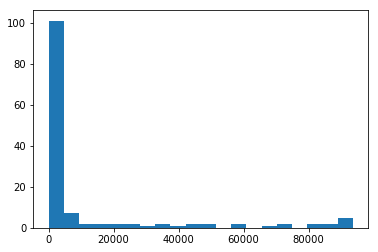

In [6]:
plt.hist(list(word_length_dict.values()), 20)
        
# a suitable maximum number of words in each sentence 80-100

In [7]:
sentence_length_dict = {}

for sent in sequences_sentences:
#     for sent in doc:
    if len(sent) not in sentence_length_dict:
        sentence_length_dict[len(sent)] = 1
    else:
        sentence_length_dict[len(sent)] += 1
            
for key in sorted(sentence_length_dict):
    print(key, sentence_length_dict[key])
    
    
# a suitable maximum number of sentences in each review 30-40

1 34130
2 70960
3 87480
4 61635
5 45395
6 28638
7 18575
8 12369
9 7664
10 6343
11 4730
12 2533
13 2157
14 1444
15 1045
16 927
17 432
18 656
19 455
20 233
21 259
22 221
23 236
24 249
25 120
26 273
27 88
28 42
29 80
30 25
31 12
32 125
33 57
34 38
35 15
36 55
37 13
39 6
40 4
41 1
42 3
44 43
45 7
46 1
48 1
49 10
50 2
51 12
53 1
54 25
58 33
59 1
72 7
107 11


(array([ 43.,   3.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([  1.00000000e+00,   4.37495000e+03,   8.74890000e+03,
          1.31228500e+04,   1.74968000e+04,   2.18707500e+04,
          2.62447000e+04,   3.06186500e+04,   3.49926000e+04,
          3.93665500e+04,   4.37405000e+04,   4.81144500e+04,
          5.24884000e+04,   5.68623500e+04,   6.12363000e+04,
          6.56102500e+04,   6.99842000e+04,   7.43581500e+04,
          7.87321000e+04,   8.31060500e+04,   8.74800000e+04]),
 <a list of 20 Patch objects>)

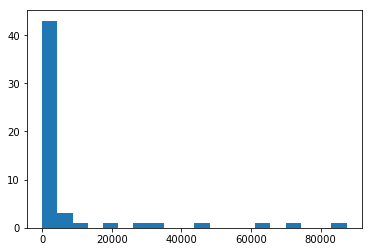

In [8]:
plt.hist(list(sentence_length_dict.values()), 20)


In [9]:
validation_split = 0.2 
epochs = 60

In [10]:
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# num_validation_samples = int(validation_split * data.shape[0])

# x_train = data[:-num_validation_samples]
# y_train = labels[:-num_validation_samples]
# x_val = data[-num_validation_samples:]
# y_val = labels[-num_validation_samples:]

## Hierarchical Attention

### Reconstruct dataset

In [11]:
max_sequence_length = 80
max_sentence_length = 30

In [12]:
def pad_seq(sent, num):
    if len(sent) >= num:
        return sent[:num]
    else:
        return [0]*(num-len(sent)) + sent

def pad_sent(sent_list, num):
    if len(sent_list) >= num:
        return sent_list[:num]
    else:
        zero_sent = [0]*len(sent_list[0])
        return [zero_sent for i in range(num-len(sent_list))] + sent_list

In [13]:
print(pad_seq([1,2,3,4], 9))
print(pad_sent([[1,1,1], [0,0,2]], 4))

[0, 0, 0, 0, 0, 1, 2, 3, 4]
[[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 2]]


In [14]:
sent_padded_sequences = [[pad_seq(sent, max_sequence_length) for sent in sent_list] for sent_list in sequences_sentences]

In [15]:
print(len(sent_padded_sequences))
print(len(sent_padded_sequences[0]))
print(len(sent_padded_sequences[0][0]))
print(type(sent_padded_sequences))

389877
4
80
<class 'list'>


In [16]:
data3d = [pad_sent(sent_list, max_sentence_length) for sent_list in sent_padded_sequences]

In [17]:
print(type(data3d))

for i in range(len(data3d)):
    if len(data3d[0]) != max_sentence_length:
        print("kk")
    
for i in range(len(data3d)):
    for j in range(len(data3d[i])):
        if len(data3d[i][j]) != max_sequence_length:
            print("pp")

<class 'list'>


In [18]:
data3d_final = np.array(data3d)

In [19]:
print(type(data3d_final))
print(type(data3d_final[0]))
print(type(data3d_final[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [20]:
print(data3d_final.shape)
print(data3d_final[0].shape)
print(data3d_final[0][0].shape)

print(data3d_final[1].shape)
print(data3d_final[1][1].shape)

print(data3d_final[2].shape)
print(data3d_final[2][2].shape)

(389877, 30, 80)
(30, 80)
(80,)
(30, 80)
(80,)
(30, 80)
(80,)


In [21]:
indices = np.arange(data3d_final.shape[0])
np.random.shuffle(indices)
data3d_final = data3d_final[indices]
labels = labels[indices]
num_validation_samples = int(validation_split * data3d_final.shape[0])

x_train = data3d_final[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data3d_final[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

print(x_train[0].shape)
print(x_train[0][0].shape)

(311902, 30, 80)
(311902, 6)
(77975, 30, 80)
(77975, 6)
(30, 80)
(80,)


### Build the model 

In [23]:
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

In [24]:
class AttLayer(Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(AttLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[-1], 1),
                                     initializer='normal',
                                     trainable=True)
#         print(self.kernel.get_shape())

        super(AttLayer, self).build(input_shape)
        
    def call(self, x, mask=None):
        eij = K.dot(x, self.kernel)
#         print(eij.get_shape(), 'eij')
        
        ai = K.exp(eij)
        weights = ai/tf.expand_dims(K.sum(ai, axis=1), -1) #ai/K.sum(ai, axis=1).dimshuffle(0, 'x')
#         print(weights.get_shape(), 'weights')
        
        weighted_input = x*weights #tf.expand_dims(weights, -1) #x*weights.dimshuffle(0, 1, 'x')
#         print(weighted_input.get_shape(), 'weighted_input')
        return tf.reduce_sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [25]:
sentence_input = Input(shape=(max_sequence_length, ), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
gru_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
dense_word = TimeDistributed((Dense(100)))(gru_word)
tanh_word = TimeDistributed(Activation('tanh'))(dense_word)
att_word = AttLayer()(tanh_word)
sentEncoder = Model(sentence_input, att_word)

review_input = Input(shape=(max_sentence_length, max_sequence_length), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
gru_sent = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
dense_sent = TimeDistributed(Dense(100))(gru_sent)
tanh_sent = TimeDistributed(Activation('tanh'))(dense_sent)
att_sent = AttLayer()(tanh_sent)
preds = Dense(6, activation='softmax')(att_sent)
model_attention = Model(review_input, preds)

In [26]:
sentEncoder.summary()
model_attention.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 100)           2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 100)           45300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 100)           10100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 80, 100)           0         
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 100)               100       
Total params: 2,055,500.0
Trainable params: 55,500.0
Non-trainable params: 2,000,000.0
_______________________________________________________

### Train the model

In [27]:
model_attention.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [30]:
filepath = "models/HierarchicalAttention-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [31]:
import time 
start_time = time.time()

model_attention.fit(x_train, y_train,
          batch_size=128,
          epochs=epochs,
          validation_data=(x_val, y_val),
            callbacks=callbacks_list)

print("Training time: ", time.time() - start_time)

Train on 311902 samples, validate on 77975 samples
Epoch 1/60
   256/311902 [..............................] - ETA: 7670s - loss: 1.0206 - acc: 0.6797

KeyboardInterrupt: 

### Save the model 

In [ ]:
model_conv_rnn.save('models/Attention.h5')